# Lecture 4: Numerical Transformations

* How to transform numerical variables to improve model fit.
* The danger of overfitting.

## Setup

Imports:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

## Transforming Variables: Interactions & Polynomial Models

Let's generate some more complicated polynomial data using the sine ([`sin`](https://numpy.org/doc/stable/reference/generated/numpy.sin.html)) function:

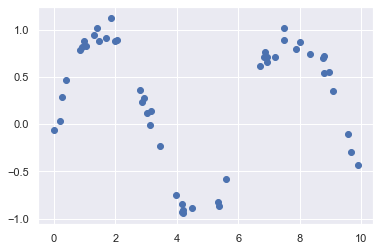

In [2]:
rng = np.random.RandomState(1)

X = 10 * rng.rand(50)
y = np.sin(X) + 0.1 * rng.randn(50)

plt.scatter(X, y);

(Using `;` at the end of the cell removes some pointless Matplotlib output.)

With **OLS**, the basic linear function we want to fit to the data is $Y=X\beta$. While the model implies linearity in the parameters ($\beta$), it does not require linearity in the variables ($X$). Very often, you will therefore want to fit models like these:
* Interactions: $Y=\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1 X_2 + \epsilon$
* Polynomial models: $Y=\beta_0 + \beta_1 X_1 + \beta_2 X_1^2 + \epsilon$

For example, a good fit for the sine-data generated above is a 7th-degree polynomial: $Y=\beta_0 + \beta_1 X_1 + \ldots + \beta_7 X_1^7 + \epsilon$.

You can fit polynomial models in two ways: you can either generate new variables for each power and their interactions (e.g., $X_1$, $X_1^2$, $X_1X_2$, ...) or you can use [`sklearn.preprocessing.PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). For example, we can use `PolynomialFeatures(7)` to indicate that we want 7th degree polynomials for all $X$'s.

We use [`sklearn.pipeline.make_pipeline()`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) to chain the polynomial feature generation and the model fitting into one. `make_pipeline()` returns a single model object, whose `fit()` method will both create the polynomial features and fit the linear model. This is useful because we don't have to move the data ourselves from the pre-processing in `PolynomialFeatures` to the model.

R2: 0.9760274753833569


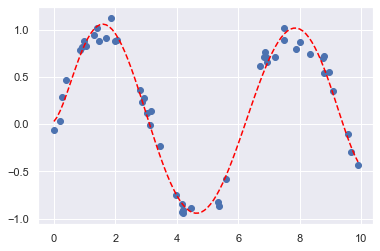

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# create model pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression(fit_intercept=True))

# apply PolynomialFeatures and fit model (in one step)
poly_model.fit(X[:, np.newaxis], y)

print(f'R2: {poly_model.score(X[:, np.newaxis], y)}')

# generate predictions
X_fit = np.arange(0, 10, .1)
y_fit = poly_model.predict(X_fit[:, np.newaxis])

# plot raw data
plt.scatter(X, y)

# plot fitted values
plt.plot(X_fit, y_fit,
         c='red', linestyle='--');

The model fits the data very well.

You can use any $f(X)$ to transform variables. `sklearn` provides a range of often used transformations in its [preprocessing](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) package.

## Over- and Underfitting

Let's generate some new data in the interval $(0,1)$:

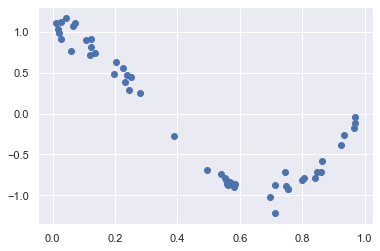

In [4]:
def dgp(X):
    return np.cos(1.5 * np.pi * X)

X = np.sort(rng.rand(50))
y = dgp(X) + rng.randn(50) * 0.1

plt.scatter(X, y);

The function `dgp(X)` represents the *data-generating process* of this example. You can see that the correct specification of any estimation model would be $Y=\beta_1 cos(1.5 \pi X) + \epsilon$.

Let's begin by fitting a *1st-degree polynomial*:

R2: 0.7103331929464758


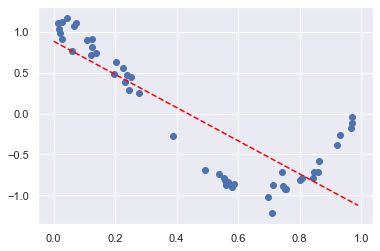

In [5]:
# create model pipeline
poly_model = make_pipeline(PolynomialFeatures(1),
                           LinearRegression(fit_intercept=True))

# transform variables and fit model
poly_model.fit(X[:, np.newaxis], y)

print(f'R2: {poly_model.score(X[:, np.newaxis], y)}')

# generate predicitions
X_fit = np.arange(0, 1, .01)
y_fit = poly_model.predict(X_fit[:, np.newaxis])

# plot raw data
plt.scatter(X, y)

# plot fitted values
plt.plot(X_fit, y_fit,
         c='red', linestyle='--');

What you can see is called **underfitting**: our linear model captures the broad direction of the effect, but otherwise fits the data poorly.

Let's have a look at a *4th-degree polynomial*:

R2: 0.9879198660522228


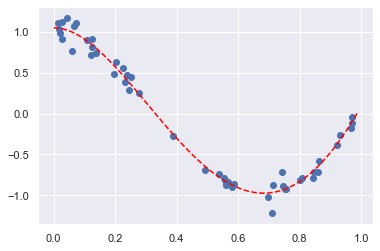

In [6]:
# create model pipeline
poly_model = make_pipeline(PolynomialFeatures(4),
                           LinearRegression(fit_intercept=True))

# transform variables and fit model
poly_model.fit(X[:, np.newaxis], y)

print(f'R2: {poly_model.score(X[:, np.newaxis], y)}')

# generate predicitions
X_fit = np.arange(0, 1, .01)
y_fit = poly_model.predict(X_fit[:, np.newaxis])

# plot raw data
plt.scatter(X, y)

# plot fitted values
plt.plot(X_fit, y_fit,
         c='red', linestyle='--');

Perfect, this is what we want. The model follows the trend of our data exactly.

Now, what happens if we further increase our model's *complexity*? This is a *15th-degree polynomial*:

R2: 0.9892974141689622


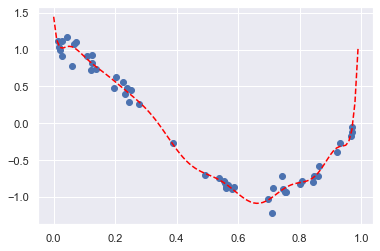

In [7]:
# create model pipeline
poly_model = make_pipeline(PolynomialFeatures(15),
                           LinearRegression(fit_intercept=True))

# transform variables and fit model
poly_model.fit(X[:, np.newaxis], y)

print(f'R2: {poly_model.score(X[:, np.newaxis], y)}')

# generate predicitions
X_fit = np.arange(0, 1, .01)
y_fit = poly_model.predict(X_fit[:, np.newaxis])

# plot raw data
plt.scatter(X, y)

# plot fitted values
plt.plot(X_fit, y_fit,
         c='red', linestyle='--');

Yes, the model fits the data better than the 7th-degree polynomial, but now it actually fits *too well*. What has happened is that the model is trying to fit too much of the random noise in the $\epsilon$'s (`np.random.randn(50) * 0.1` in `dgp(X)`). This is called **overfitting**. It is a problem, because any overfitted model is likely to perform very poorly on data it has never seen.

This example is from the [sklearn doc](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html).

### A Second Example

The resolution of polynomials is fairly limited, so let's take a look at another transformation that easily overfits. We return to our first data set:

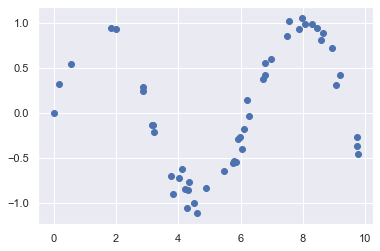

In [8]:
X = 10 * rng.rand(50)
y = np.sin(X) + 0.1 * rng.randn(50)

plt.scatter(X, y);

We now transform our $X$'s using the $n$-th degree [Gaussian function](https://en.wikipedia.org/wiki/Gaussian_function) $e^{-\frac{1}{2}\frac{X-\bar{x}}{\sigma}}$, where $\bar{x}$ is one of $n$ equally-spaced centre points between $min\{X\}$ and $max\{X\}$.

It is not part of this course how the Gaussian transformation works or why we use it, so if you just want to focus on the key parts of this lecture, you can skip the next section.

#### Gaussian (Data Generating) Process

Let's begin with this transformer class [from the book](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Gaussian-basis-functions) that does all the hard work for us:

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input
    From https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)

The Gaussian transformer takes two *hyperparameters*:
* `N`: the number of functions
* `width_factor`: how wide the functions should be, i.e., how overlapping

We fit the transformer on our $X$'s to calculate the equally-spaced centre points (`gf.centres_`) and the distance between them (`gf.width_`):

In [10]:
gf = GaussianFeatures(5)
gf.fit(X[:,np.newaxis])
X_fit = np.arange(0, 10, .1)

The intuition behind this approach is that we want to represent the data generating process as the sum of several Gaussian functions. This is equivalent to saying that for each $X$, $Y$ is some combination of a number of Gaussian functions.

The figure below illustrates the principle: each $X$ is mapped to 5 values on the 5 Gaussian functions (in colour). The $Y$ for each $X$ is then some weighted (parameterised, the $\beta$'s in our models) sum of these values.

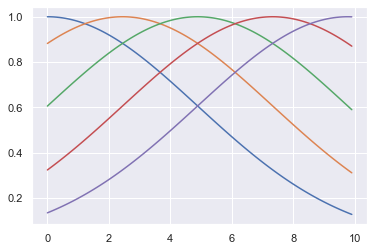

In [11]:
for cp in gf.centers_:
    plt.plot(X_fit,
             np.exp(-(X_fit - cp)**2 / (2 * (gf.width_)**2)))

For example, $X=5$ corresponds to
* $\approx0.6$ on the blue and purple Gaussian functions;
* $\approx0.9$ on the red and orange functions; and
* $1.0$ on the green function.

A 5th-degree Gaussian model estimates this equation:

\\(Y=\beta_0 + \beta_1 e^{-\frac{1}{2}\frac{X-\bar{x}_1}{\sigma}} + \ldots + \beta_5 e^{-\frac{1}{2}\frac{X-\bar{x}_5}{\sigma}} + \epsilon\\)

where $\bar{x}_n$ are the $n \in [1,5]$ equally-spaced centre points (or maxima) of our Gaussian functions, and $\sigma$ is the constant distance between them.

To get the transformed $X$'s, we need to call `gf.transform()`:

In [12]:
gf.transform(X[:, np.newaxis])

array([[0.22409552, 0.46958562, 0.76634228, 0.97399598, 0.96409076],
       [0.17936979, 0.399956  , 0.69454679, 0.93932781, 0.98937113],
       [0.64214731, 0.90725397, 0.99827332, 0.85545355, 0.5709128 ],
       [0.53508422, 0.8259954 , 0.99302344, 0.92975335, 0.67795736],
       [0.26270811, 0.52509223, 0.81738012, 0.99092078, 0.93557838],
       [0.84299695, 0.9964403 , 0.91728215, 0.65762904, 0.3671854 ],
       [0.60445215, 0.88098091, 0.99999413, 0.88400512, 0.60860917],
       [0.47140212, 0.76809831, 0.97469439, 0.9632666 , 0.74139716],
       [0.99951976, 0.89584964, 0.62532421, 0.33993958, 0.14392115],
       [0.47808381, 0.7745073 , 0.97717732, 0.96016886, 0.73476462],
       [0.67445054, 0.92765934, 0.99369548, 0.82898084, 0.53859466],
       [0.25507382, 0.51442632, 0.8079916 , 0.98836394, 0.94157152],
       [0.81223165, 0.98955208, 0.93890962, 0.6938016 , 0.39927598],
       [0.18803023, 0.41393186, 0.70966993, 0.94756788, 0.98535027],
       [0.49678448, 0.79202645, 0.

We can see that each observation (row) now holds 5 transformed X values. These values are *exactly* the values we would've gotten by finding the corresponding `Y` values for the original `X` on the above graph.

Now, why is this Gaussian transformation useful in DS? Because it gives our model much more flexibility in terms of fitting to several polynomial trends. We'll see this now:

#### Fitting a Model with Gaussian Features

Like before with the `PolynomialFeatures` transformer, we can use the `GaussianFeatures` transformer in the `make_pipeline()`method:

R2: 0.9811491350343224


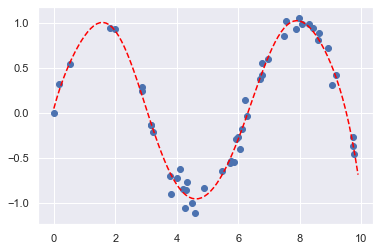

In [13]:
# create model pipeline
gauss_model = make_pipeline(GaussianFeatures(10),
                            LinearRegression())

# transform variables and fit model
gauss_model.fit(X[:, np.newaxis], y)

print(f'R2: {gauss_model.score(X[:, np.newaxis], y)}')

# generate predicitions
X_fit = np.arange(0, 10, .1)
y_fit = gauss_model.predict(X_fit[:, np.newaxis])

# plot raw data
plt.scatter(X, y)

# plot fitted values
plt.plot(X_fit, y_fit,
         c='red', linestyle='--');

With 10 Gaussian features, the model fits the data very well. We do not see much overfitting.

Let's increase the number of functions to 30:

R2: 0.9897400249929883


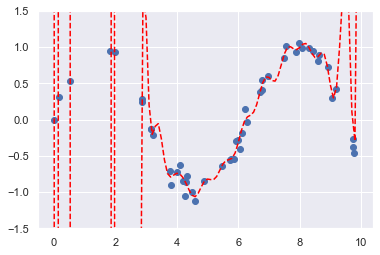

In [14]:
# create model pipeline
gauss_model = make_pipeline(GaussianFeatures(30),
                            LinearRegression(fit_intercept=True))

# transform variables and fit model
gauss_model.fit(X[:, np.newaxis], y)

print(f'R2: {gauss_model.score(X[:, np.newaxis], y)}')

# generate predicitions
X_fit = np.arange(0, 10, .1)
y_fit = gauss_model.predict(X_fit[:, np.newaxis])

# plot raw data
plt.scatter(X, y)

# plot fitted values
plt.plot(X_fit, y_fit,
         c='red', linestyle='--');

plt.ylim(-1.5, 1.5);

This is a beautiful example of **overfitting**: while each data point is covered (the blue dots are close to the red line), the predictions in the gaps between the data points go in all directions. The original data generating process is completely lost in this model (compare it to the 10-Gaussian model or the polynomial model further above). This makes it impossible to use this model in production. Nonetheless, the model's $R^2$ is better than before, so initially we might be inclined to adopt this model.

© 2023 Philipp Cornelius